C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\280663348.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\280663348.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  SöOmr_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(SöOmr_df), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\280663348.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_effekt = SöOmr_df["TOTel"].resample("M").max()  # Högsta värde per månad
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\280663348.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users\jak

Summa kostnad i el 2023: 39615342.27744203
Original elförbrukning topptimmar:     Timme  Elförbrukning
0    7219       3908.200
1    8059       3843.131
2    8443       3840.423
3    8251       3824.813
4    8395       3794.349
5    7435       3783.307
6    6761       3768.287
7    8442       3756.027
8    7044       3715.430
9    7962       3713.003
10   7915       3707.637
11   8467       3704.873
12   7890       3673.619
13   8732       3670.221
14   6786       3660.640
15   8419       3658.394
16   6546       3655.243
17   7603       3653.145
18   8731       3651.873
19   6929       3648.403
20   7243       3645.646
21   6738       3644.875
22   8060       3635.661
23   6737       3623.693
24   6905       3621.269
25   7914       3594.335
26   8250       3593.372
27   7218       3593.023
28   6714       3584.694
29   6906       3581.508
Snitt originaltopptimmar: 3691.6364666666673

Genomsnittligt dagligt Depth of Discharge (DoD) under året: 17.50%
Snitt = 3691.64
De 30 högsta elför

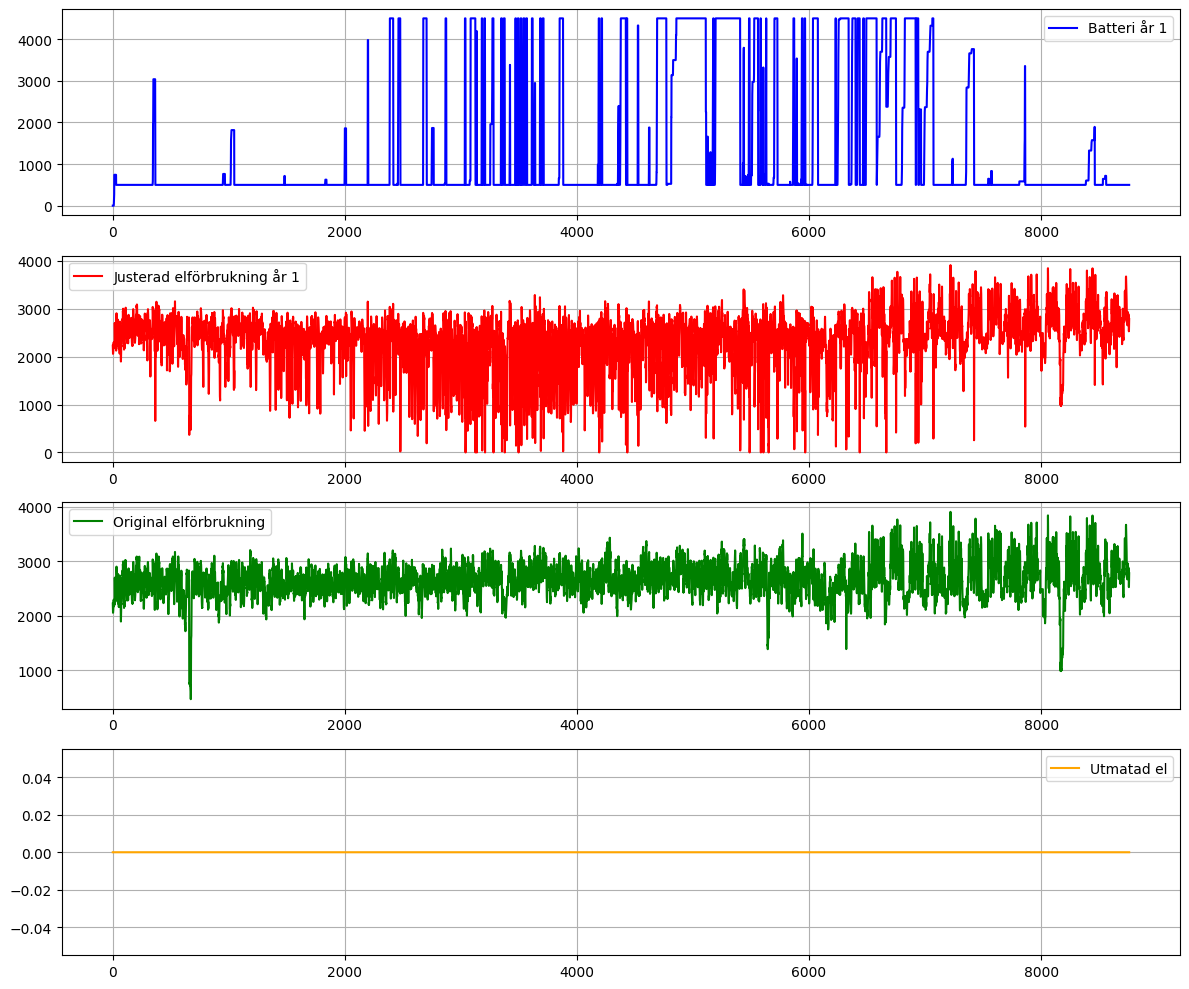

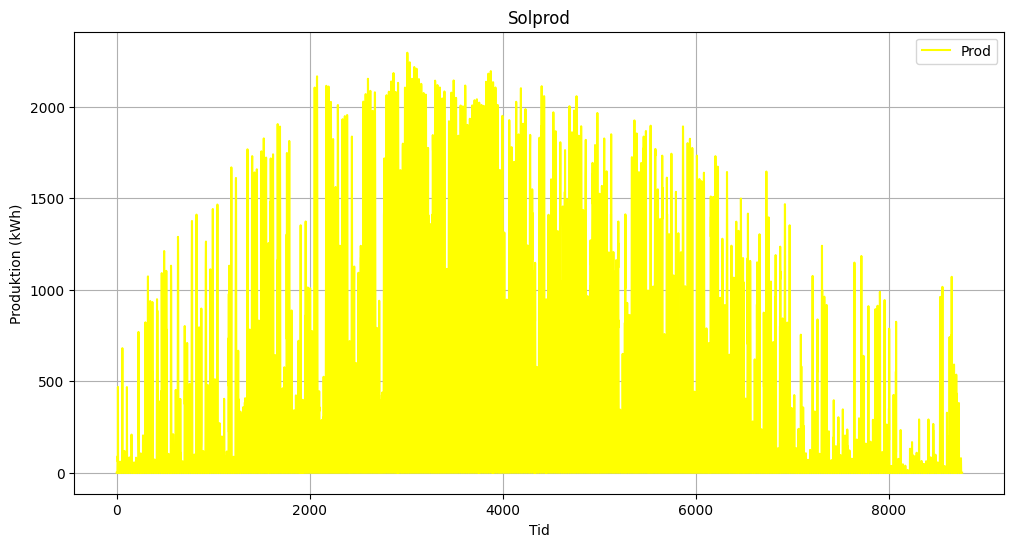

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx", header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
SödraOmr = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx", header=None)

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.8*Solprod.iloc[:, 0]  #SOL+VIND = 0.4, SOL= 0.8
Spot = Spotpris.iloc[:, 0]
SöOmr = SödraOmr.iloc[:,0]

Prod =  Sol

Prod_list = Prod.tolist()

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

fastNätTOT = 266104

SöOmr_df = pd.DataFrame({"TOTel": SöOmr})
SöOmr_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(SöOmr_df), freq="H")
SöOmr_df.set_index("Tid", inplace=True)

# Hitta maximal timmedeleffekt per månad
monthly_max_effekt = SöOmr_df["TOTel"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad = effektkostnad_per_månad.sum()

Spotpris["E"] = 2.23 + 0.0583 * Spotpris["Spotpris"]

# Beräkna genomsnittlig överföringsavgift per månad
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna totala elförbrukningen per månad
monthly_total_TOTel = SöOmr_df["TOTel"].resample("M").sum()

# Beräkna summa överföringsavgift för hela året
summaÖverföringsAvgift = (monthly_avg_E * monthly_total_TOTel).sum()

totElnätskostnad = fastNätTOT + total_effektkostnad + summaÖverföringsAvgift/100

elhandelskostnad = (Spot * SöOmr).sum() / 100
energiskatt = (43.9 * SöOmr).sum() / 100

summaElKostnad = (totElnätskostnad + elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(SöOmr)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())
print("Snitt originaltopptimmar: " + str(top_30_hours.mean()))

# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
faktor = 0.1
original_consumption = SöOmr.tolist()
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for tid, prod, söomr, spot in zip(Spotpris.index, Prod, SöOmr, Spot):  
    diff = söomr - prod  # Skillnad mellan förbrukning och solproduktion

    if diff <= 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        utmatning.append(max(0,batteriKapacitet - diff - max_battery_level))
        köptaTimmar.append((tid,0))
    else:
        if spot <= 30 and prod > 0:
            if batteriKapacitet + prod >= max_battery_level: 
                prodÖver = (batteriKapacitet + prod) - max_battery_level
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                köpt_el = max(0, söomr-prodÖver)
                elförbrukning.append(köpt_el)  
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                utmatning.append(0)
            else:
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                elförbrukning.append(söomr)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)  
        elif 30 < spot < 70 and prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 70:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, max(0, batteriKapacitet-min_battery_level))
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            elförbrukning.append(köpt_el)
            utmatning.append(0)
        else:
            elförbrukning.append(söomr)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)


# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(elförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

values_only = [value for value, _ in sorted_pairs]
mean_value = sum(values_only) / len(values_only)
print(f"Snitt = {mean_value:.2f}")

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")

for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")

köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT
# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()

In [ ]:
from scipy.optimize import minimize

def kostnadsfunktion(x):
    spot_lower, spot_upper, battery_size = x
    
    # Begränsa till rimliga värden
    if spot_lower >= spot_upper or battery_size < 1000 or battery_size > 10000:
        return 1e9  # Högt straff

    batteriKapacitet = 0.0
    batteriMaxKapacitet = battery_size
    min_battery_level = batteriMaxKapacitet * 0.1
    max_battery_level = batteriMaxKapacitet * 0.9
    maxFrånBatteri = max_battery_level * 0.5

    elförbrukning = []
    battery_values = []
    utmatning = []
    köptaTimmar = []

    for tid, prod, söomr, spot in zip(Spotpris.index, Prod, SöOmr, Spot):
        diff = söomr - prod

        if diff <= 0:
            batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)
            elförbrukning.append(0)
            utmatning.append(max(0, batteriKapacitet - diff - max_battery_level))
            köptaTimmar.append((tid, 0))
        else:
            if spot <= spot_lower and prod > 0:
                if batteriKapacitet + prod >= max_battery_level:
                    prodÖver = (batteriKapacitet + prod) - max_battery_level
                    batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                    köpt_el = max(0, söomr - prodÖver)
                    elförbrukning.append(köpt_el)
                    köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                    utmatning.append(0)
                else:
                    batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                    elförbrukning.append(söomr)
                    köptaTimmar.append((tid, spot))
                    utmatning.append(0)
            elif spot_lower < spot < spot_upper and prod > 0:
                elförbrukning.append(diff)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)
            elif spot >= spot_upper:
                energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))
                batteriKapacitet -= energiFrånBatteri
                köpt_el = max(0, diff - energiFrånBatteri)
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                elförbrukning.append(köpt_el)
                utmatning.append(0)
            else:
                elförbrukning.append(söomr)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)

        battery_values.append(batteriKapacitet)

    köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
    köptaTimmar_df.set_index("Tid", inplace=True)
    köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

    monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
    elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
    elförbrukning_df.set_index("Tid", inplace=True)
    monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

    summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()
    summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT

    elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]
    elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

    total_elförbrukning = sum(elförbrukning)
    JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

    kostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
    return kostnad


start = [35, 85.27, 5000]  # startvärden
bounds = [(0, 100), (0, 200), (1000, 10000)]

result = minimize(kostnadsfunktion, start, bounds=bounds)

print("Optimala spotpriströsklar & batterikapacitet:")
print(f"Spotpris lower: {result.x[0]:.2f} öre/kWh")
print(f"Spotpris upper: {result.x[1]:.2f} öre/kWh")
print(f"Batterikapacitet: {result.x[2]:.0f} kWh")
print(f"Årskostnad: {result.fun:.2f} kr")



C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipyker

Optimala spotpriströsklar & batterikapacitet:
Spotpris lower: 35.00 öre/kWh
Spotpris upper: 85.27 öre/kWh
Batterikapacitet: 10000 kWh
Årskostnad: 28487443.28 kr


C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_23212\17694913.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()


C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\1161861391.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\1161861391.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  SöOmr_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(SöOmr_df), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\1161861391.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_max_effekt = SöOmr_df["TOTel"].resample("M").max()  # Högsta värde per månad
C:\Users\jakob\AppData\Local\Temp\ipykernel_21580\1161861391.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users

Summa kostnad i el 2023: 39614004.97654588
Original elförbrukning topptimmar:     Timme  Elförbrukning
0    7218       3908.200
1    8058       3843.131
2    8442       3840.423
3    8250       3824.813
4    8394       3794.349
5    7434       3783.307
6    6760       3768.287
7    8441       3756.027
8    7043       3715.430
9    7961       3713.003
10   7914       3707.637
11   8466       3704.873
12   7889       3673.619
13   8731       3670.221
14   6785       3660.640
15   8418       3658.394
16   6545       3655.243
17   7602       3653.145
18   8730       3651.873
19   6928       3648.403
20   7242       3645.646
21   6737       3644.875
22   8059       3635.661
23   6736       3623.693
24   6904       3621.269
25   7913       3594.335
26   8249       3593.372
27   7217       3593.023
28   6713       3584.694
29   6905       3581.508
Snitt originaltopptimmar: 3691.6364666666673

Genomsnittligt dagligt Depth of Discharge (DoD) under året: 0.00%
Snitt = 3689.76
De 30 högsta elförb

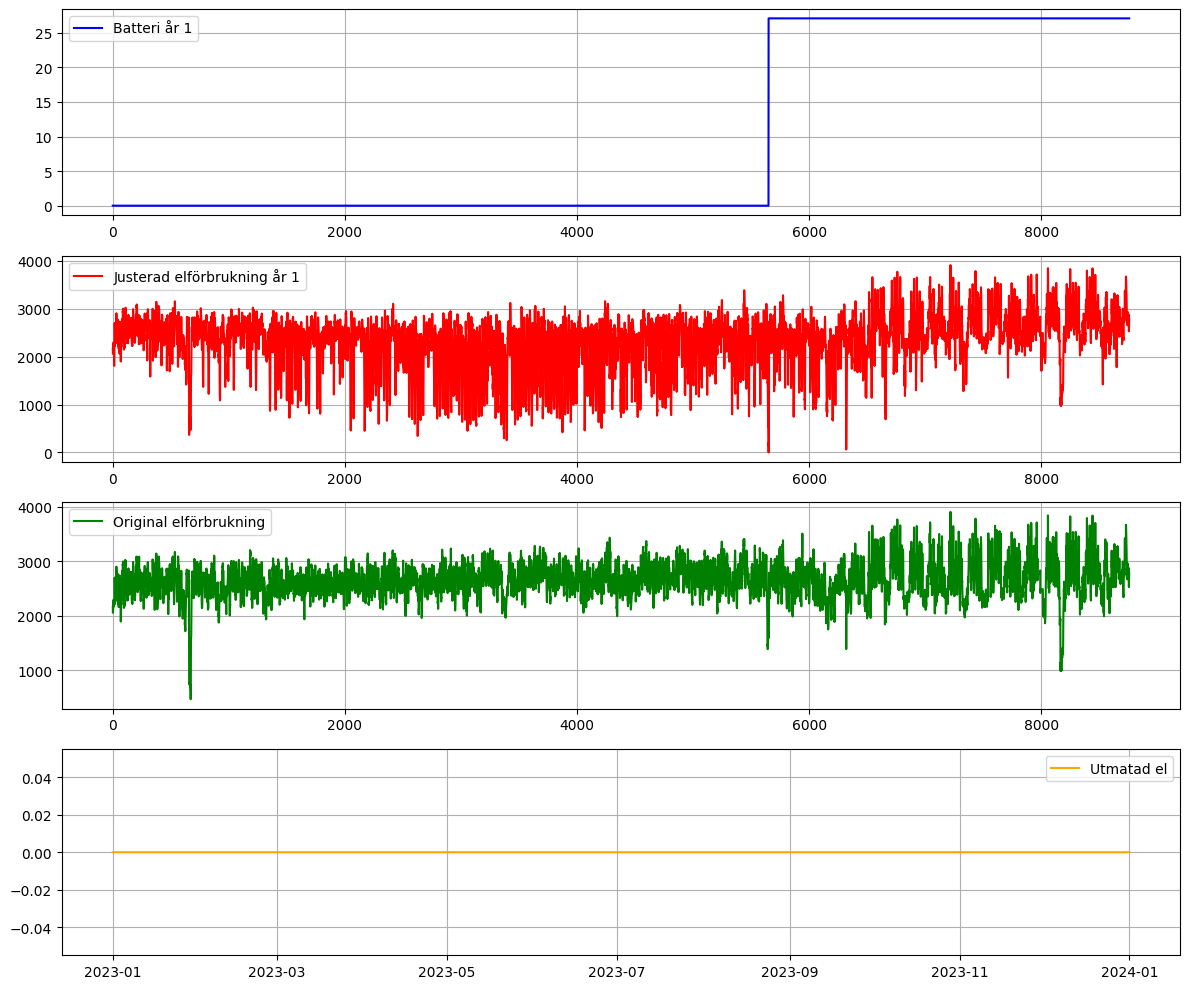

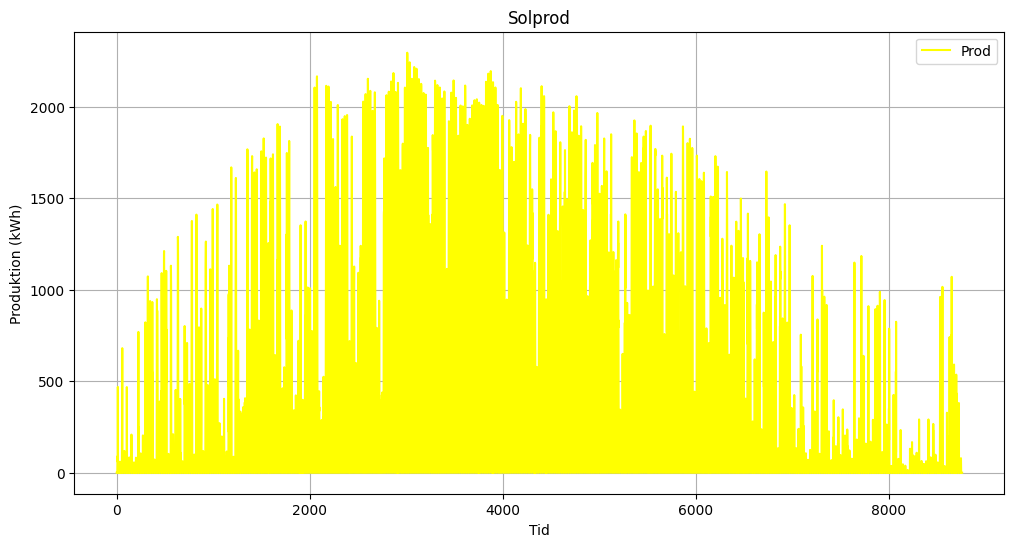

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx")
SödraOmr = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx")

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.8*Solprod.iloc[:, 0]  # VIND+SOL=0.6, SOL = 0.8
Spot = Spotpris.iloc[:, 0]
SöOmr = SödraOmr.iloc[:,0]

Prod =  Sol

Prod_list = Prod.tolist()

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

fastNätTOT = 266104

SöOmr_df = pd.DataFrame({"TOTel": SöOmr})
SöOmr_df["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(SöOmr_df), freq="H")
SöOmr_df.set_index("Tid", inplace=True)

# Hitta maximal timmedeleffekt per månad
monthly_max_effekt = SöOmr_df["TOTel"].resample("M").max()  # Högsta värde per månad

# Effektavgift (per kW)
effektavgift = 57.04  # kr/kW

# Beräkna effektkostnad per månad
effektkostnad_per_månad = monthly_max_effekt * effektavgift  # Kostnad per månad

# Summera effektkostnaden för hela året
total_effektkostnad = effektkostnad_per_månad.sum()

Spotpris["E"] = 2.23 + 0.0583 * Spotpris["Spotpris"]

# Beräkna genomsnittlig överföringsavgift per månad
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna totala elförbrukningen per månad
monthly_total_TOTel = SöOmr_df["TOTel"].resample("M").sum()

# Beräkna summa överföringsavgift för hela året
summaÖverföringsAvgift = (monthly_avg_E * monthly_total_TOTel).sum()

totElnätskostnad = fastNätTOT + total_effektkostnad + summaÖverföringsAvgift/100

elhandelskostnad = (Spot * SöOmr).sum() / 100
energiskatt = (43.9 * SöOmr).sum() / 100

summaElKostnad = (totElnätskostnad + elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(SöOmr)

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())
print("Snitt originaltopptimmar: " + str(top_30_hours.mean()))

# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
original_consumption = SöOmr.tolist()
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for i, (tid, prod, söomr, spot) in enumerate(zip(Spotpris.index, Prod, SöOmr, Spot)):
    diff = söomr - prod  # Difference between consumption and solar production


    if i < 2800:
        faktor = 0.15
    elif  2500 <= i <= 7500:
        faktor = 0.3
    else:
        faktor = 0.07

    if diff <= 0:
        if batteriKapacitet - diff >= max_battery_level:
            utmatEl = batteriKapacitet - diff - max_battery_level
            utmatning.append((tid, utmatEl))
            batteriKapacitet = max_battery_level  # -diff eftersom diff är negativ
        else:
            utmatning.append((tid, 0))
            batteriKapacitet = batteriKapacitet - diff
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        elförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:  
        
        if 15 <= tid.hour < 19 and prod == 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, söomr - energiFrånBatteri)
            elförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif 15 <= tid.hour < 19 and prod > 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, diff, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            elförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append((tid, 0))
        elif prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append((tid,0))
            
        else:
            elförbrukning.append(söomr)  
            köptaTimmar.append((tid, spot))
            utmatning.append((tid, 0))

    
    battery_values.append(batteriKapacitet)



# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(elförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

values_only = [value for value, _ in sorted_pairs]
mean_value = sum(values_only) / len(values_only)
print(f"Snitt = {mean_value:.2f}")

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")
for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 2.23 + 0.0583 * köptaTimmar_df["Spotpris"]

monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastNätTOT
# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (summaJusteradÖverfKR + JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
utmatning_tid, utmatning_värde = zip(*utmatning)  # Dela upp tuples i två listor
ax[3].plot(utmatning_tid, utmatning_värde, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()